<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BE223C_SPRING_2021/blob/main/make_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2

from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra

# Load data from google drive
#

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/My Drive/DBT_DATA/IMG_ARRAYS'
top_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES' 
csv_dir = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/'


#output patch save dir
patch_normal_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/NORMAL'
patch_actionable_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/ACTIONABLE' 
patch_benign_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/BENIGN'
patch_cancer_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER'


     |████████████████████████████████| 1.9MB 3.9MB/s 
     |████████████████████████████████| 133kB 4.0MB/s 
Mounted at /content/gdrive


In [ ]:
#file = os.path.join(data_dir,'DBT-P05056_DBT-S01839_rmlo_Cancer.pickle')
#img_data = pickle.load( open( file, "rb" ) )
#dims = np.shape(img_data)

file = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00303/01-01-2000-DBT-S02436-MAMMO diagnostic digital bilateral-33835/14595.000000-79329/1-1.dcm'
#'/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00303/01-01-2000-DBT-S02436-MAMMO diagnostic digital bilateral-33835/Breast-Cancer-Screening-DBT/DBT-P00303/01-01-2000-DBT-S02436-MAMMO diagnostic digital bilateral-33835/14595.000000-79329/1-1.dcm'
#01-01-2000-DBT-S05386-MAMMO screening digital bilateral-70928/7697.000000-17471/1-1.dcm'



img_data = dcmread_image(file,'rcc')

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


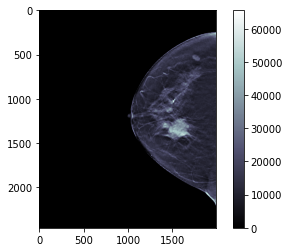

In [ ]:
plt.figure()
plt.imshow(img_data[21,:,:], cmap='bone')
plt.colorbar()


MISSING USER DEFINED BOX DATA


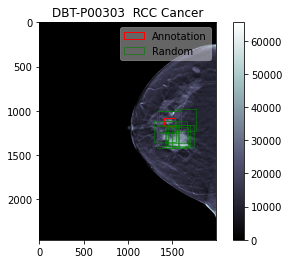

In [ ]:
plt.figure()
plt.imshow(img_data[21,:,:], cmap='bone')
plt.colorbar()


rect = patches.Rectangle((1411,1080),124,92,linewidth=1,edgecolor='r',facecolor='none')

# Get the current reference
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(rect)

for ii in range(0,10):
    xr = random.randint(int(1411*.9),int(1411*1.1))
    yr = random.randint(int(1080*.9),int(1080*1.1))

    #define square for original box choice
    user_rect = patches.Rectangle((xr, yr),244,244,linewidth=0.6,edgecolor='green',facecolor='none')
    ax.add_patch(user_rect)
else:
    print('MISSING USER DEFINED BOX DATA')

ax.legend(['Annotation','Random'],fancybox=True, framealpha=0.4)
plt.title('DBT-P00303  RCC Cancer')
plt.show()

In [ ]:
!ls '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00303/01-01-2000-DBT-S02436-MAMMO diagnostic digital bilateral-33835/14595.000000-79329/1-1.dcm'

'/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00303/01-01-2000-DBT-S02436-MAMMO diagnostic digital bilateral-33835/14595.000000-79329/1-1.dcm'


In [ ]:
#code borrowed from
#https://gist.github.com/cmarasinou/7c990a4835e80874b4de5f2433612d65
###############testing out embedded function, as .py import failing

from typing import AnyStr, BinaryIO, Optional, Union

import numpy as np
import pydicom as dicom
from skimage.exposure import rescale_intensity


def dcmread_image(
    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
    view: str,
    index: Optional[np.uint] = None,
) -> np.ndarray:
    """Read pixel array from DBT DICOM file"""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name='pillow') #pylibjpeg')
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])
    if index is not None:
        pixel_array = pixel_array[index]
    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))
        print("Laterality fixed!")
    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(
        pixel_array, in_range=(low, high), out_range="dtype"
    )
    return pixel_array


def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Unreliable - DICOM laterality is incorrect for some cases"""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value


def _get_image_laterality(pixel_array: np.ndarray) -> str:
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"


def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)


def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

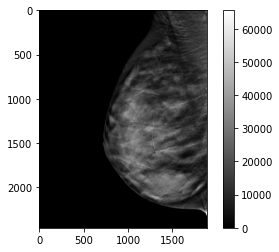

In [ ]:
plt.figure()
plt.imshow(img_data[5,:,:],cmap='gray')
plt.colorbar()